# Compose TensorFlow Decision Forests and Neural Networks

This notebook shows you how to compose multiple TensorFlow [Decision Forests](https://www.tensorflow.org/decision_forests) and Neural Networks together using a common preprocessing layer and the [Keras functional API](https://keras.io/guides/functional_api/).

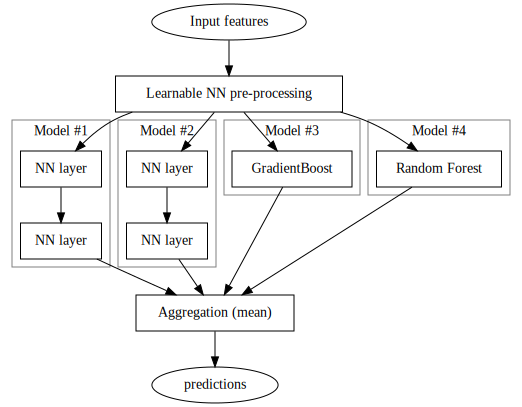

In [1]:
from graphviz import Source

Source("""
digraph G {
  raw_data [label="Input features"];
  preprocess_data [label="Learnable NN pre-processing", shape=rect];

  raw_data -> preprocess_data

  subgraph cluster_0 {
    color=grey;
    a1[label="NN layer", shape=rect];
    b1[label="NN layer", shape=rect];
    a1 -> b1;
    label = "Model #1";
  }

   subgraph cluster_1 {
    color=grey;
    a2[label="NN layer", shape=rect];
    b2[label="NN layer", shape=rect];
    a2 -> b2;
    label = "Model #2";
  }

  subgraph cluster_2 {
    color=grey;
    a3[label="GradientBoost", shape=rect];
    label = "Model #3";
  }

  subgraph cluster_3 {
    color=grey;
    a4[label="Random Forest", shape=rect];
    label = "Model #4";
  }
  

  preprocess_data -> a1;
  preprocess_data -> a2;
  preprocess_data -> a3;
  preprocess_data -> a4;

  b1  -> aggr;
  b2  -> aggr;
  a3 -> aggr;
  a4 -> aggr;
  
  aggr [label="Aggregation (mean)", shape=rect]
  aggr -> predictions
}
""")

In [2]:
!pip install tensorflow_decision_forests -U --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx-bsl 1.4.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.4.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.0 which is incompatible.
tensorflow-transform 1.4.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.4.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.0 which is incompatible.
tensorflow-transform 1.4.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,<2.7,>=1.15.2, but you have tensorflow 2.7.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.7.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorf

In [3]:
import os, glob, math, cv2, gc, logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow_decision_forests as tfdf
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")
tf.autograph.set_verbosity(0)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print(tf.__version__)

2.7.0


# Load and Preprocess Data

In [4]:
train = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv').set_index("row_id")
test = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv').set_index("row_id")

sample_submission = pd.read_csv("../input/tabular-playground-series-jan-2022/sample_submission.csv")

In [5]:
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek

test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek

In [6]:
train["month"] = train["month"].astype('category')
train["dayofweek"] = train["dayofweek"].astype('category')
train["day"] = train["day"].astype('category')

test["month"] = test["month"].astype('category')
test["dayofweek"] = test["dayofweek"].astype('category')
test["day"] = test["day"].astype('category')

# Some plots to get insight from data

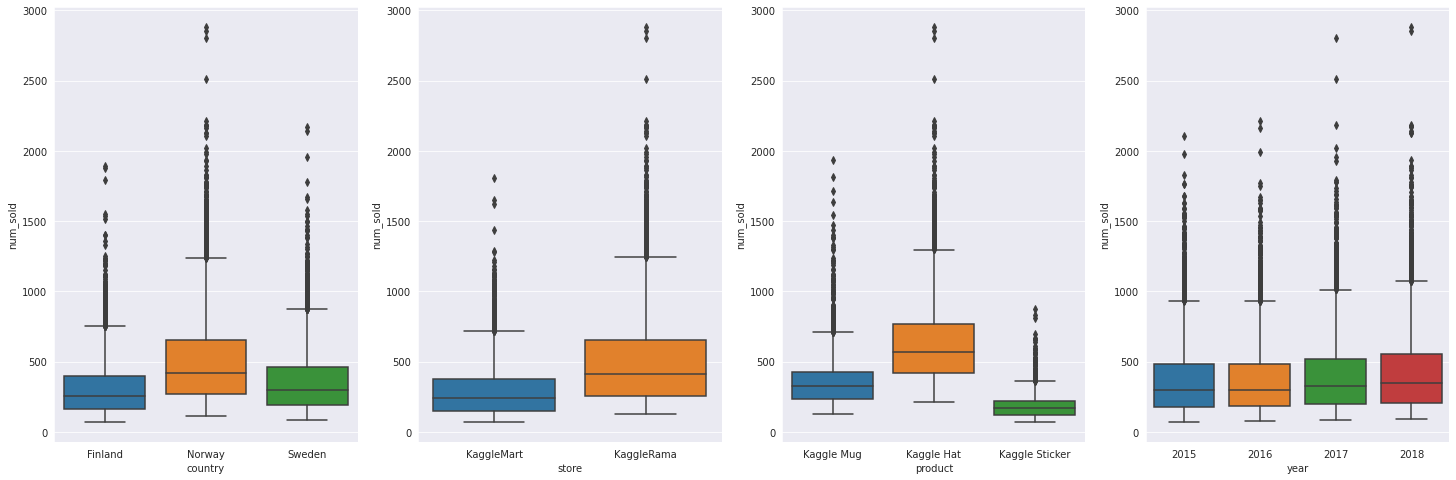

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(25, 8))
sns.boxplot(data=train, x='country', y='num_sold', ax=ax[0])
sns.boxplot(data=train, x='store', y='num_sold', ax=ax[1])
sns.boxplot(data=train, x='product', y='num_sold', ax=ax[2])
sns.boxplot(data=train, x='year', y='num_sold', ax=ax[3])
plt.show()

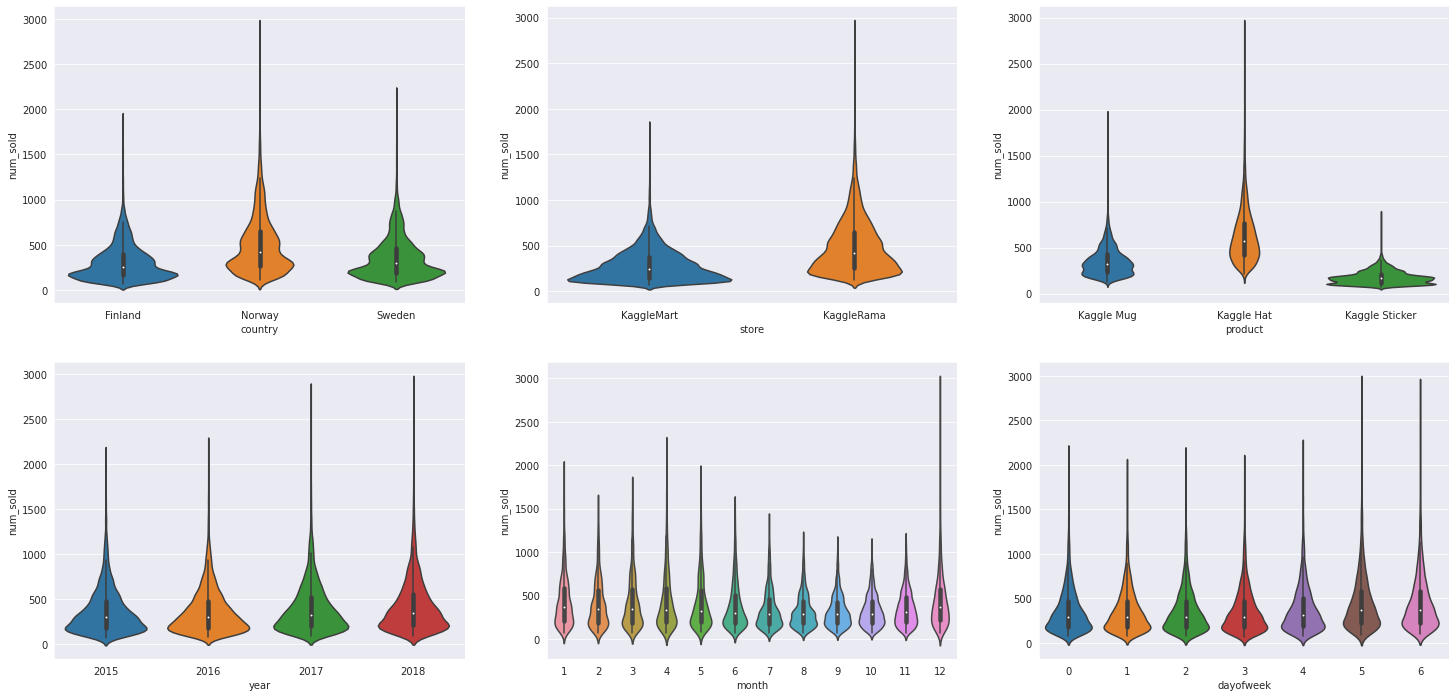

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(25, 12))
sns.violinplot(data=train, x='country', y='num_sold', ax=ax[0][0])
sns.violinplot(data=train, x='store', y='num_sold', ax=ax[0][1])
sns.violinplot(data=train, x='product', y='num_sold', ax=ax[0][2])
sns.violinplot(data=train, x='year', y='num_sold', ax=ax[1][0])
sns.violinplot(data=train, x='month', y='num_sold', ax=ax[1][1])
sns.violinplot(data=train, x='dayofweek', y='num_sold', ax=ax[1][2])
plt.show()

# Add More Features

 - Thanks to [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) for the [GDP dataset](https://www.kaggle.com/carlmcbrideellis/gdp-20152019-finland-norway-and-sweden).
 - Thanks to [@vpallares](https://www.kaggle.com/vpallares) for the [Holidays dataset](https://www.kaggle.com/vpallares/public-and-unofficial-holidays-nor-fin-swe-201519).

## GDP

In [9]:
GDP_data = pd.read_csv("../input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv").set_index("year")
GDP_data.columns = ['Finland', 'Norway', 'Sweden']
GDP_dictionary = GDP_data.unstack().to_dict()
train["GDP"] = train.set_index(['country','year']).index.map(GDP_dictionary.get)
test["GDP"] = test.set_index(['country','year']).index.map(GDP_dictionary.get)

sc = MinMaxScaler()
train["GDP"] = sc.fit_transform(train["GDP"].values.reshape(-1,1))
test["GDP"] = sc.transform(test["GDP"].values.reshape(-1,1))

## Holidays

In [10]:
holidays_data = pd.read_csv("../input/public-and-unofficial-holidays-nor-fin-swe-201519/holidays.csv")
train["is_holiday"] = train.date.isin(holidays_data["date"]).astype(np.uint8)
test["is_holiday"] = test.date.isin(holidays_data["date"]).astype(np.uint8)

## Remove Redundant Columns

In [11]:
train_date = train["date"]
test_date = test["date"]
train.drop(["date", "year"], inplace=True, axis=1)
test.drop(["date", "year"], inplace=True, axis=1)

## One-Hoe Encode Categorical Columns

In [12]:
ohe_cols = ["country","store","product", "month", "dayofweek", "day"]

train = pd.get_dummies(train, columns=["month"], prefix="o_month")
test = pd.get_dummies(test, columns=["month"], prefix="o_month")

train = pd.get_dummies(train, columns=["day"], prefix="o_day")
test = pd.get_dummies(test, columns=["day"], prefix="o_day")

train = pd.get_dummies(train, columns=["dayofweek"], prefix="o_week")
test = pd.get_dummies(test, columns=["dayofweek"], prefix="o_week")

train = pd.get_dummies(train, columns=["country","store","product"], prefix="ohe")
test = pd.get_dummies(test, columns=["country","store","product"], prefix="ohe")

train.head()

,num_sold,GDP,is_holiday,o_month_1,o_month_2,o_month_3,o_month_4,o_month_5,o_month_6,o_month_7,...,o_week_5,o_week_6,ohe_Finland,ohe_Norway,ohe_Sweden,ohe_KaggleMart,ohe_KaggleRama,ohe_Kaggle Hat,ohe_Kaggle Mug,ohe_Kaggle Sticker
row_id,,,,,,,,,,,,,,,,,,,,,
0,329,0.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,520,0.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,146,0.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,572,0.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,911,0.0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0


# Split Data and Make Dataset

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(train[train.columns.tolist()[1:]], train.num_sold, test_size=0.2, random_state=42)
print(f"x_train  shape: {x_train.shape}")
print(f"y_train  shape: {y_train.shape}\n")
print(f"x_valid  shape: {x_valid.shape}")
print(f"y_valid  shape: {y_valid.shape}")

x_train  shape: (21038, 60)
y_train  shape: (21038,)

x_valid  shape: (5260, 60)
y_valid  shape: (5260,)


In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.values.astype("float32"), y_train.values.astype("float32"))).batch(64)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid.values.astype("float32"), y_valid.values.astype("float32"))).batch(64)

# Create Model

In [15]:
def seed_advanced_argument(seed):
    return tfdf.keras.AdvancedArguments(yggdrasil_training_config=tfdf.keras.core.YggdrasilTrainingConfig(random_seed=seed))

inputs = layers.Input(shape=(x_train.shape[-1],))

# learnable pre-processing
x = tf.keras.layers.Dense(1024, activation=tf.nn.relu6)(inputs)
preprocess_features = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(x)

preprocessor = tf.keras.Model(inputs, preprocess_features)

# Model #1: Neural Network 1
m1_z1 = tf.keras.layers.Dense(256, activation=tf.nn.relu6)(preprocess_features)
m1_z1 = tf.keras.layers.Dropout(0.2)(m1_z1)
m1_z1 = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(m1_z1)
m1_pred = tf.keras.layers.Dense(1)(m1_z1)

# Model #2: Neural Network 2
m2_z1 = tf.keras.layers.Dense(128, activation=tf.nn.swish)(preprocess_features)
m2_z1 = tf.keras.layers.Dropout(0.2)(m2_z1)
m2_z1 = tf.keras.layers.Dense(64, activation=tf.nn.swish)(m2_z1)
m2_pred = tf.keras.layers.Dense(1)(m2_z1)

# Model #3: DF Gradient Boost Trees
model_3 = tfdf.keras.GradientBoostedTreesModel(num_trees=10000, 
                                               advanced_arguments=seed_advanced_argument(1234), 
                                               task=tfdf.keras.Task.REGRESSION)
m3_pred = model_3(preprocess_features)

# Model #4: DF Random Forest
model_4 = tfdf.keras.RandomForestModel(num_trees=2000,
                                               advanced_arguments=seed_advanced_argument(2022), 
                                               task=tfdf.keras.Task.REGRESSION)
m4_pred = model_4(preprocess_features)

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)
mean_nn_and_df = tf.reduce_mean(tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)


ensemble_nn_only = tf.keras.models.Model(inputs, mean_nn_only)
ensemble_nn_and_df = tf.keras.models.Model(inputs, mean_nn_and_df)

Use /tmp/tmpo7jwhx7p as temporary training directory
Use /tmp/tmpcw0hrtpn as temporary training directory


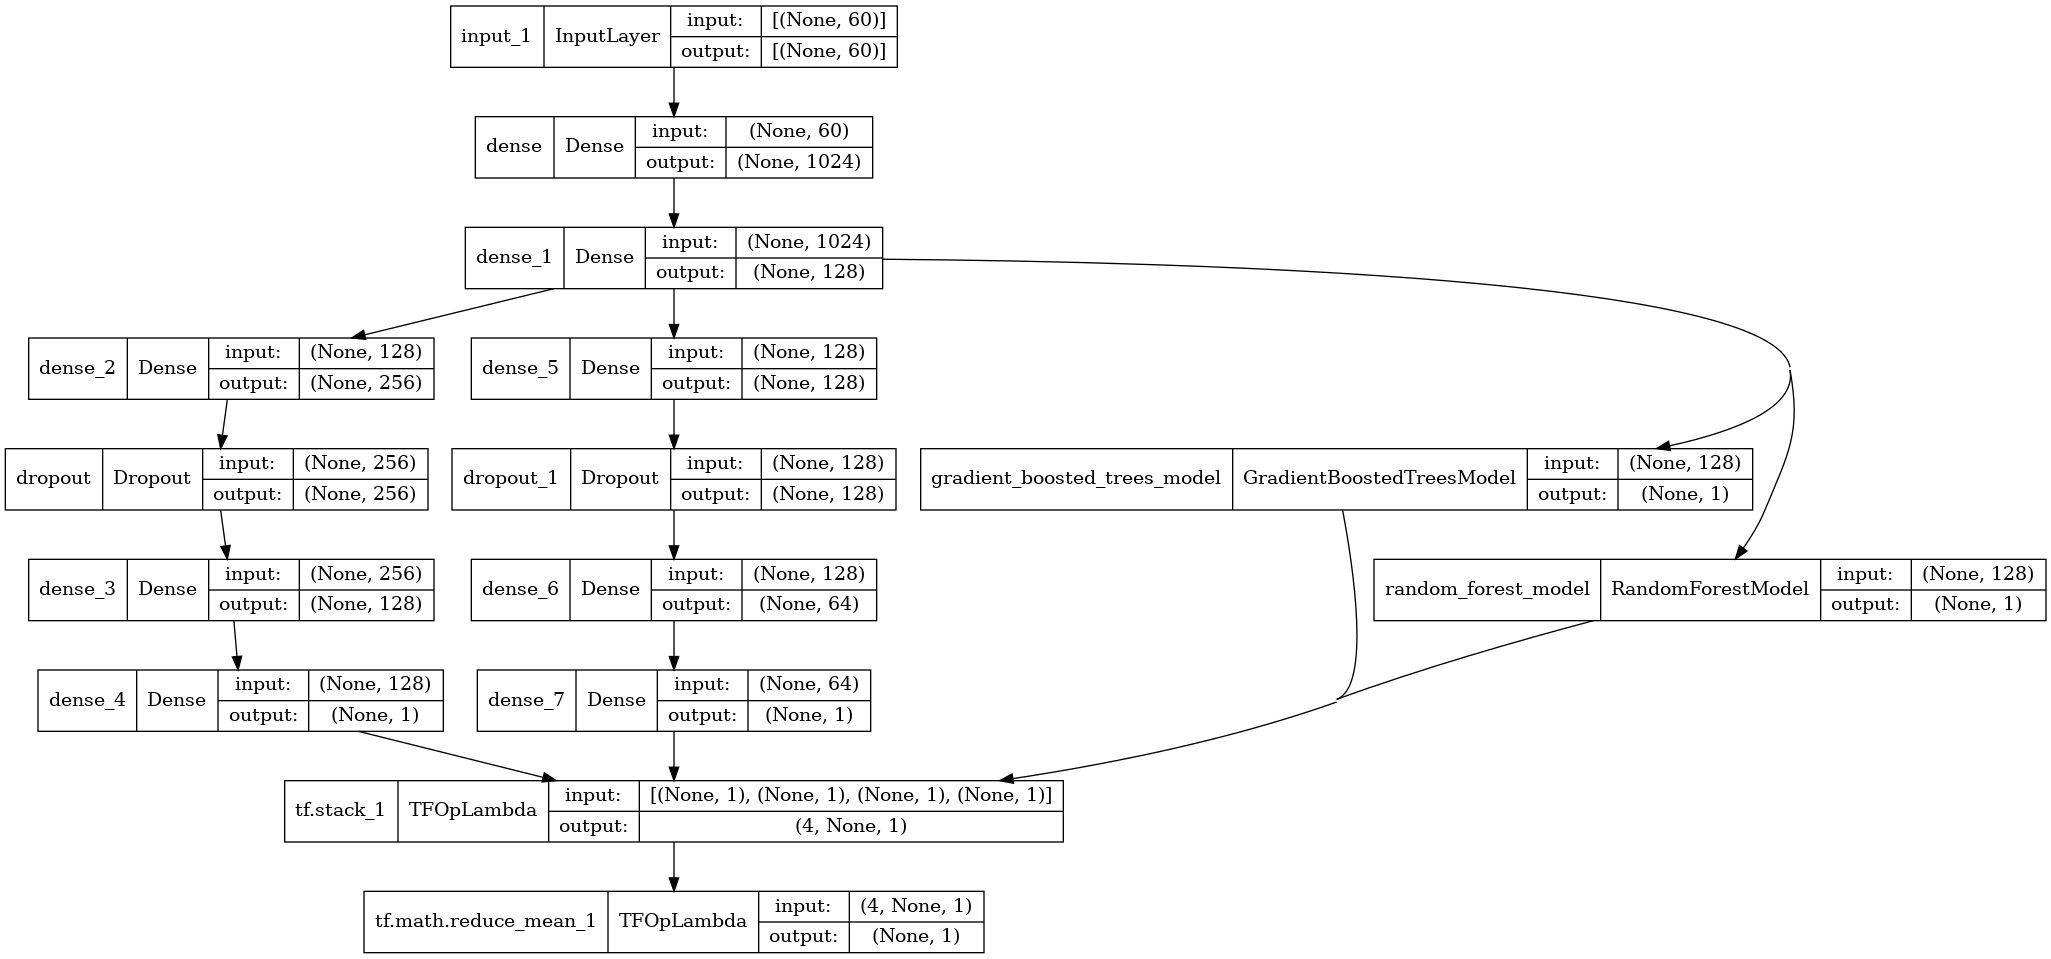

In [16]:
plot_model(ensemble_nn_and_df, to_file="model.png", show_shapes=True)

# Train Neural Network Models 🧠

In [17]:
def smape(y_true, y_pred):
    denominator = (y_true + tf.abs(y_pred)) / 200.0
    diff = tf.abs(y_true - y_pred) / denominator
    diff = tf.where(denominator==0, 0.0, diff)
    return tf.reduce_mean(diff)

cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, mode="min", restore_best_weights=True, verbose=1)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, mode="min", min_lr=1e-6, verbose=1)

ensemble_nn_only.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=smape, metrics=[smape])

history = ensemble_nn_only.fit(train_dataset, 
                               epochs=100,
                               validation_data=valid_dataset,
                               callbacks=[cb_es, cb_lr],
                               verbose=2)

Epoch 1/100
329/329 - 3s - loss: 61.1670 - smape: 61.1567 - val_loss: 46.6823 - val_smape: 46.5821 - lr: 0.0010 - 3s/epoch - 9ms/step
Epoch 2/100
329/329 - 2s - loss: 37.3219 - smape: 37.3148 - val_loss: 27.3482 - val_smape: 27.2928 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/100
329/329 - 2s - loss: 24.4719 - smape: 24.4696 - val_loss: 21.9311 - val_smape: 21.9074 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 4/100
329/329 - 2s - loss: 20.9769 - smape: 20.9699 - val_loss: 15.0354 - val_smape: 15.0006 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/100
329/329 - 2s - loss: 13.0826 - smape: 13.0799 - val_loss: 9.6926 - val_smape: 9.6663 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 6/100
329/329 - 2s - loss: 10.5676 - smape: 10.5657 - val_loss: 8.5553 - val_smape: 8.5322 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 7/100
329/329 - 2s - loss: 8.9987 - smape: 8.9981 - val_loss: 7.3748 - val_smape: 7.3609 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 8/100
329/329 - 2s - loss: 8.3085 - smape: 8.3086 - val_loss: 8.

# Train TF Decision Forest Models (TFDF) 🎄 🌴 🌳

TFDF does not support (yet) GPUs and TPUs. Therefore, the training process may be slow. You can get much higher accuracy by amending the decision trees arguments (for example `num_trees` or increasing pre-processed features).

In [18]:
%%time
train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y)).unbatch().batch(1024)
valid_dataset_with_preprocessing = valid_dataset.map(lambda x,y: (preprocessor(x), y)).unbatch().batch(1024)

model_3.compile([smape])
model_4.compile([smape])

print("\n-------------#3 Training TFDF Gradinet Boost Trees -------------\n")
model_3.fit(train_dataset_with_preprocessing)
evaluation_df3_only = model_3.evaluate(valid_dataset_with_preprocessing, return_dict=True)

print("\n-------------#4 Training TFDF Random Forest -------------\n")
model_4.fit(train_dataset_with_preprocessing)
evaluation_df4_only = model_4.evaluate(valid_dataset_with_preprocessing, return_dict=True)


-------------#3 Training TFDF Gradinet Boost Trees -------------

Starting reading the dataset
     20/Unknown - 7s 18ms/step
Dataset read in 0:00:07.718721
Training model
Model trained in 0:00:27.142206
Compiling model
7/7 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - smape: 4.9606

-------------#4 Training TFDF Random Forest -------------

Starting reading the dataset
     20/Unknown - 2s 18ms/step
Dataset read in 0:00:01.911460
Training model
Model trained in 0:11:04.279851
Compiling model
7/7 [==============================] - 5s 578ms/step - loss: 0.0000e+00 - smape: 4.9073
CPU times: user 44min 8s, sys: 42.4 s, total: 44min 51s
Wall time: 12min 53s


# Evaluate Models

In [19]:
print("Model Neural Network Only:")
evaluation_nn_only = ensemble_nn_only.evaluate(valid_dataset)
print("\nModel TFDF Gradient Boost Trees Only:")
evaluation_df3_only = model_3.evaluate(valid_dataset_with_preprocessing, return_dict=True)
print("\nModel TFDF Random Forest Only:")
evaluation_df4_only = model_4.evaluate(valid_dataset_with_preprocessing, return_dict=True)

ensemble_nn_and_df.compile(loss=smape, metrics=[smape])
print("\nEnsembeled Neural Networks and TFDF Models:")
evaluation_nn_and_df = ensemble_nn_and_df.evaluate(valid_dataset, return_dict=True)

Model Neural Network Only:
83/83 [==============================] - 0s 2ms/step - loss: 4.8469 - smape: 4.8429

Model TFDF Gradient Boost Trees Only:
7/7 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - smape: 4.9606

Model TFDF Random Forest Only:
7/7 [==============================] - 5s 588ms/step - loss: 0.0000e+00 - smape: 4.9073

Ensembeled Neural Networks and TFDF Models:
83/83 [==============================] - 6s 57ms/step - loss: 4.8073 - smape: 4.8019


In [20]:
sample_train_data = train.loc[(train["ohe_Finland"]==1) & (train["ohe_KaggleMart"]==1) & (train["ohe_Kaggle Hat"]==1)]
p = ensemble_nn_and_df.predict(sample_train_data[sample_train_data.columns.tolist()[1:]]).astype('int32')

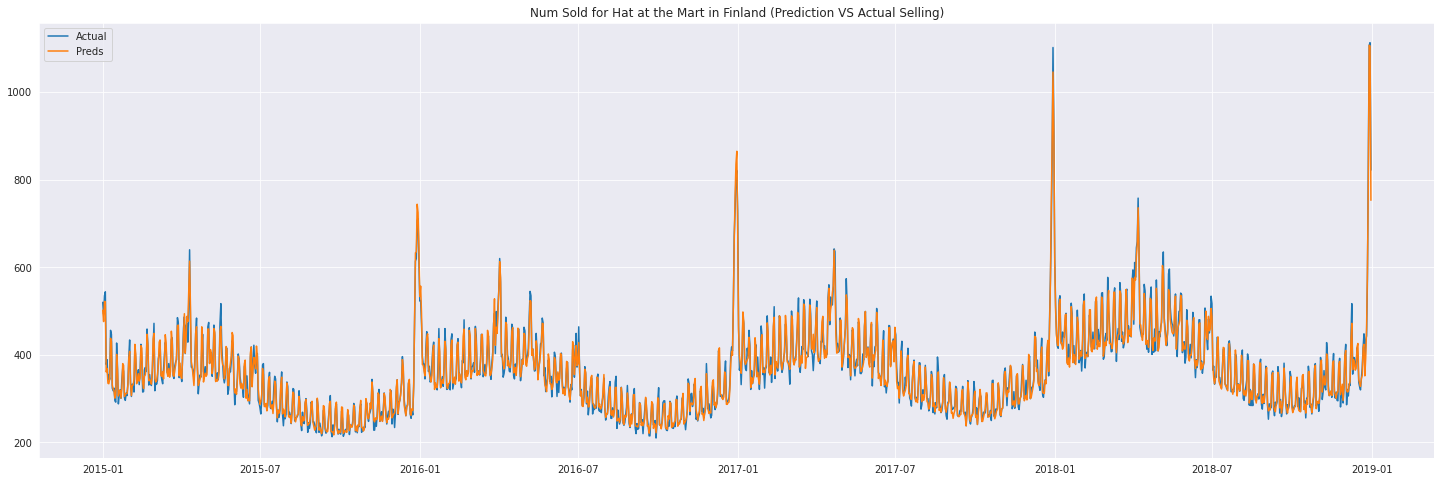

In [21]:
plt.figure(figsize=(25,8))
sns.lineplot(y=sample_train_data["num_sold"].values, x=train_date.unique())
sns.lineplot(y=p.ravel(), x=train_date.unique())
plt.legend(["Actual", "Preds"])
plt.title("Num Sold for Hat at the Mart in Finland (Prediction VS Actual Selling)")
plt.show()

# Create Submission

In [22]:
preds = ensemble_nn_and_df.predict(test).astype('int32')
sample_submission["num_sold"] = preds.ravel()
sample_submission.to_csv("submission.csv", index=False)
sample_submission

,row_id,num_sold
0,26298,386
1,26299,579
2,26300,168
3,26301,649
4,26302,1011
...,...,...
6565,32863,811
6566,32864,217
6567,32865,921
6568,32866,1364


# Plot Test Predictions

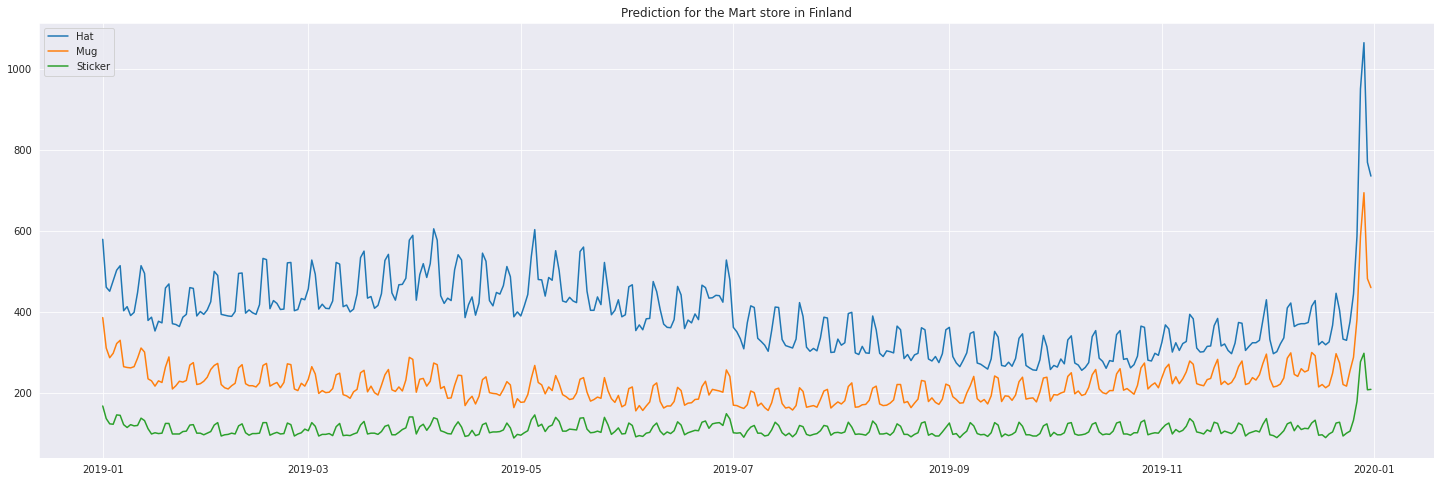

In [23]:
p_1 = ensemble_nn_and_df.predict(test.loc[(test["ohe_Finland"]==1) & (test["ohe_KaggleMart"]==1) & (test["ohe_Kaggle Hat"]==1)]).astype('int32')
p_2 = ensemble_nn_and_df.predict(test.loc[(test["ohe_Finland"]==1) & (test["ohe_KaggleMart"]==1) & (test["ohe_Kaggle Mug"]==1)]).astype('int32')
p_3 = ensemble_nn_and_df.predict(test.loc[(test["ohe_Finland"]==1) & (test["ohe_KaggleMart"]==1) & (test["ohe_Kaggle Sticker"]==1)]).astype('int32')

plt.figure(figsize=(25,8))
sns.lineplot(y=p_1.ravel(), x=test_date.unique())
sns.lineplot(y=p_2.ravel(), x=test_date.unique())
sns.lineplot(y=p_3.ravel(), x=test_date.unique())
plt.title("Prediction for the Mart store in Finland")
plt.legend(["Hat", "Mug", "Sticker"])
plt.show()

Source: [Composing Decision Forest and Neural Network models](https://www.tensorflow.org/decision_forests/tutorials/model_composition_colab)